In [1]:
%matplotlib inline

In [2]:
import numpy as np
import kali.carma
import kali
import gatspy
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [14,8]
from lsstlc import * # derived LSST lightcurve sub-class

/home/kali/python/kali/lc.py:29: UserWarning: No display environment! Using matplotlib backend "Agg"
  warnings.warn('No display environment! Using matplotlib backend "Agg"')
/home/conda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Generate DRW LC

In [4]:
# load MAF output from file, which was saved from the obs_hist notebook
maf = np.load('/home/mount/MAF output/58_-27_poster.npz') 

# get the result for minion_1016, baseline cadence
bl_meta = maf['meta1'] # [ra, dec, min_gap, opsim_id], min_gap in hours
bl_cadence = maf['cadence1'] # cadence in structured array

# result for baseline with no pairs
# bl_np_meta = maf['meta2']

# bl_np_cadence = maf['cadence2']

#rolling cadence
roll_meta = maf['meta3']
roll_cadence = maf['cadence3']

In [5]:
# determine lowest seperation between three different cadence
sep = np.array([float(bl_meta[2]), float(roll_meta[2])])
min_sep = np.min(sep)

### CARMA(1,0) task

In [5]:
# Initiate carma task
Task = kali.carma.CARMATask(1,0,nsteps = 500)

In [6]:
# declare input timescales and amplitude, organize in an array
r_1 = (-1.0/150.0) + 0j 
amp = 1.0
Rho = np.array([r_1, amp])

# use helper function to convert input to coefficients, and check whether valid
Theta = kali.carma.coeffs(1, 0, Rho) # use the array of roots above to solve for coefficients
print Theta # print out the calculated coefficients
print Task.check(Theta)

[ 0.00666667  0.11547005]
True


### Simulate DRW LC

In [7]:
dt = min_sep/24 # convert min_gap from hours to days, Kali uses days
Task.set(dt, Theta) # Will print 0 if parameters set successfuly

0

In [ ]:
DRW_lc = Task.simulate(duration=3650)

In [ ]:
# plot simulated lightcurve
f = plt.figure()
plt.ylabel('Flux')
plt.xlabel('t(days)')
plt.plot(DRW_lc.t, DRW_lc.x, color='gray') # x is the variation about the mean flux

### Add noise (based on 100 SN ratio)

In [20]:
DRW_lc.fracNoiseToSignal = 0.01
Task.observe(DRW_lc)

#### Save to file

In [ ]:
lc2file('/home/mount/c10_58_-27_lc', DRW_lc)

#### From file

In [6]:
DRW_lc = extLC('/home/mount/c10_58_-27_lc.npz')

In [8]:
DRW_lc.fracNoiseToSignal = 0.01 # need fix, read from saved lc not updating

0.001

## Downsample DRW

#### Baseline Cadence (minion_1016)

In [7]:
bl_down = lsstlc(bl_meta[0], bl_meta[1], bl_cadence['expDate'], DRW_lc, float(min_sep))

In [12]:
# For Rachael:
import pandas as pd

df = pd.DataFrame.from_records(bl_cadence[:-1])
df['obsTimes (days)'] = bl_down.t
df['absFlux'] = bl_down.y
df['fluxErr'] = bl_down.yerr

df.to_csv('/home/mount/lsst_cadence/Rachael/wfd_drw.csv', index=False)

#### Baseline Cadence without exposure in pairs (kraken_1043)

In [ ]:
bl_np_down = lsstlc(bl_meta[0], bl_meta[1], bl_np_cadence['expDate'], DRW_lc, float(min_sep))

#### Rolling Cadence V2 (enigma_1260)

In [13]:
roll_down = lsstlc(bl_meta[0], bl_meta[1], roll_cadence['expDate'], DRW_lc, float(min_sep))

### Plot down-sampled onto the whole mock lc

In [14]:
# get mean flux
mean = - np.mean(DRW_lc.x) + np.mean(DRW_lc.y)

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True)
f.set_figheight(12)
f.set_figwidth(15)

# ax1.set(ylabel='Fractional Variability')
ax1.errorbar(bl_down.mock_t, bl_down.x/mean, bl_down.yerr/mean, fmt='o', label='Baseline Cadence', 
             zorder=4, capsize=2, markersize=5)
ax1.plot(bl_down.mockLC.t, (bl_down.mockLC.x)/mean, color='gray')
ax1.set_xlim(0,3650)
ax1.set_ylabel('Fractional Variability')
ax1.legend(numpoints=1, loc=2)

# ax2.errorbar(bl_np_down.mock_t, bl_np_down.x/mean, bl_np_down.yerr/mean, color='r', 
#              fmt='o', label='Baseline No Pair', zorder=8)
# ax2.plot(bl_down.mockLC.t, (bl_down.mockLC.x)/mean, color='gray')
# ax2.set(ylabel='Fractional Variability')
# ax2.legend(numpoints=1)

ax2.errorbar(roll_down.mock_t, roll_down.x/mean, roll_down.yerr/mean, color='green', 
             fmt='o', label='Rolling Cadence', zorder=4, capsize=2, markersize=5)
ax2.plot(bl_down.mockLC.t, (bl_down.mockLC.x)/mean, color='gray')
ax3.set(xlabel='Time(days)')
ax2.set_ylabel('Fractional Variability')
ax2.legend(numpoints=1,loc=2)

ax3.hist([bl_cadence['expDate']/86400, roll_cadence['expDate']/86400], bins=10, 
         color=['b', 'g'], label=['Baseline Cadence', 'Rolling Cadence'])
ax3.set_ylim(0,650)
ax3.set_ylabel('Number of Visits')
ax3.legend(loc=2)
#plt.savefig('/home/mount/fig_1.png', dpi=300)

## Poster fig

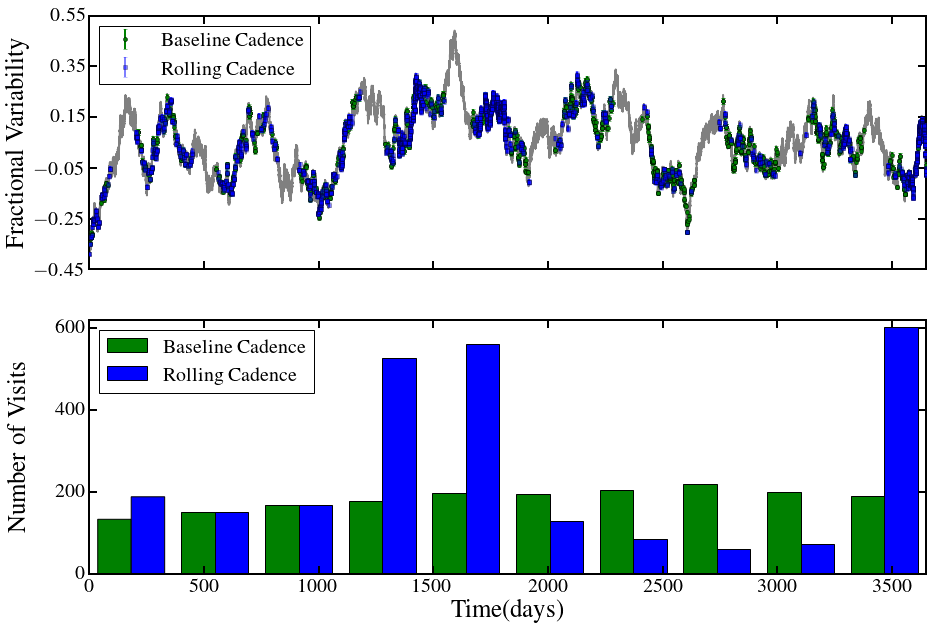

In [53]:
f, (ax1, ax2) = plt.subplots(2,1,sharex=True)
f.set_figheight(10)
f.set_figwidth(15)

# ax1.set(ylabel='Fractional Variability')
ax1.errorbar(bl_down.mock_t, bl_down.x/mean, bl_down.yerr/mean, fmt='o', label='Baseline Cadence', 
             zorder=4, capsize=2, markersize=4, color='g')
ax1.errorbar(roll_down.mock_t, roll_down.x/mean, roll_down.yerr/mean, color='blue', 
             fmt='s', label='Rolling Cadence', zorder=4, capsize=2, markersize=4, alpha=0.5)
ax1.plot(bl_down.mockLC.t, (bl_down.mockLC.x)/mean, color='gray')
ax1.set_xlim(0,3650)
ax1.set_ylim(-0.45,0.55)
mticks = np.arange(-0.45, 0.75, 0.2)
ax1.set_yticks(mticks)
ax1.set_ylabel('Fractional Variability',fontsize=25)
ax1.legend(numpoints=1, loc='upper left', borderpad=0.3)

ax2.hist([bl_cadence['expDate']/86400, roll_cadence['expDate']/86400], bins=10, 
         color=['g', 'b'], label=['Baseline Cadence', 'Rolling Cadence'])
ax2.set_ylim(0,620)
ax2.set_ylabel('Number of Visits',fontsize=25, labelpad=25)
ax2.legend(loc=2)
ax2.locator_params(axis='y', nbins=4)
ax2.set_xlabel('Time(days)', fontsize=25)
plt.savefig('/home/mount/fig1.png', dpi=500)

### Compare number of visit for each cadence

In [ ]:
print 'The location of the sky we are looking at is ({}, {})'.format(bl_meta[0], bl_meta[1])
print 'The # of visit for baseline cadence: {}'.format(bl_down.x.shape[0])
#print 'The # of visit for baseline cadence without pair exposures: {}'.format(bl_np_down.x.shape[0])
print 'The # of visit for rolling cadence: {}'.format(roll_down.x.shape[0])

### Now checkout the best-fit parameters

Here we are comparing two parameters, first one is $\tau$, the relexation time-scale, the second is $\sigma$ the amplitude of the variation.

In [35]:
Task.fit(bl_down)
print 'Baseline cadence (WFD+DDF), minion_1016'
print ' Input parameters: \n {}'.format([150, 1])
print ' Best-fit paremeters:\n {}'.format(Task.bestTau)

Baseline cadence (WFD+DDF), minion_1016
 Input parameters: 
 [150, 1]
 Best-fit paremeters:
 [ 108.62430097    0.86859541]


In [ ]:
Task.clear()
Task.fit(bl_np_down)
print 'Baseline cadence (WFD+DDF) without pair exposure, kraken_1043'
print ' Input parameters: \n {}'.format([150, 1])
print ' Best-fit paremeters:\n {}'.format(Task.bestTau)

In [ ]:
Task.clear()
Task.fit(roll_down)
print 'Rolling cadence, enigma_1260'
print ' Input parameters: \n {}'.format([150, 1])
print ' Best-fit paremeters:\n {}'.format(Task.bestTau)

## Poster PSD

In [36]:
bestTheta = np.array([ 0.00920643,  0.1178611 ])

In [37]:
Task.set(dt, bestTheta)

0

In [38]:
start = 1/DRW_lc.T
stop = 1/(DRW_lc.mindt*4)

In [39]:
# psd for drw model
freqs, psd, psdn, psdd, psdnc, psddc = Task.psd(start=start, stop=stop)

In [40]:
# psd for mock light curve
from astropy import stats
ls = stats.LombScargle(DRW_lc.t[0::4], DRW_lc.y[0::4], DRW_lc.yerr[0::4], nterms=1)
f_mock, psd_mock = ls.autopower(method='fast', normalization='psd', minimum_frequency=start, maximum_frequency=stop)

In [41]:
# psd for bl_down
ls_down = stats.LombScargle(bl_down.t, bl_down.y, bl_down.yerr, nterms=1)
f, p = ls_down.autopower(method='fast',normalization='psd', minimum_frequency=start, maximum_frequency=stop)

In [42]:
down2mock = psd_mock[0]/p[0]
drw2mock = psd_mock[0]/psd[0]

In [43]:
nf_mock = np.append(f_mock[:10000], f_mock[10000::10])
npsd_mock = np.append(psd_mock[:10000], psd_mock[10000::10])
nf = np.append(f[:10000], f[10000::10])
nps = np.append(p[:10000], p[10000::10])

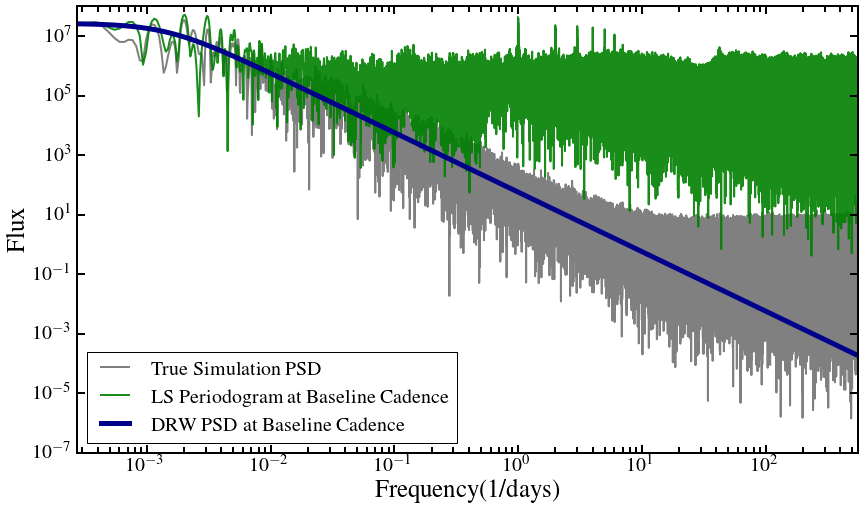

In [65]:
plt.loglog(nf_mock, npsd_mock, color='gray', label='True Simulation PSD')
plt.loglog(nf, nps*down2mock, color='g', alpha=0.9, label='LS Periodogram at Baseline Cadence')
plt.loglog(freqs, psd*drw2mock, linewidth=5, color='darkblue',label='DRW PSD at Baseline Cadence')
plt.xlim(freqs[0], freqs[-1])
plt.ylim(10e-8, 10e7)
plt.xlabel('Frequency(1/days)', fontsize=25)
plt.ylabel('Flux', fontsize=25)
plt.legend(loc=3)
#plt.savefig('/home/mount/fig2.png', dpi=300)